1.set variabel

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
''' Set parameters '''
scale = 2
size = 32  # Input size
aug_num = 4  # Number of image augmentations, the maximum value is 4
num_G = 32  # Number of convolution kernels
lr = 1e-4  # Learning rate
Imgflag = 0  # The way of reading images. 0: RGB, 1: GRAY, 2: Y channel from Y_CrCb form
if Imgflag == 0:
    channels = 3
else:
    channels = 1

Imglist = ['RGB', 'GRAY', 'YCrCb']
print('Have got parameters, for ' + Imglist[Imgflag] + ' images.')

Have got parameters, for RGB images.


2.utils

In [ ]:
import cv2
import os
import numpy as np
import math
from tqdm import tqdm


def delcrust(HR_img, scale, Imgflag, Rflag=0):
    HR_size = HR_img.shape
    rem0 = HR_size[0] % scale
    rem1 = HR_size[1] % scale
    if Imgflag == 0:
        HR_img = HR_img[:HR_size[0] - rem0, :HR_size[1] - rem1, :]  # Cut edges that cannot be divisible by scale
    else:
        HR_img = HR_img[:HR_size[0] - rem0, :HR_size[1] - rem1]
    ''' Rflag=0，get HR；Rflag=1，get LR；Rflag=2，get ILR'''
    if Rflag == 0:
        return HR_img
    if Rflag == 1 or Rflag == 2:
        HR_size = HR_img.shape
        HR_size = (HR_size[1], HR_size[0])
        LR_size = (int(HR_size[0] / scale), int(HR_size[1] / scale))
        LR_img = cv2.resize(HR_img, LR_size, interpolation=cv2.INTER_LINEAR)
        if Rflag == 1:
            return LR_img
        else:
            ILR_img = cv2.resize(LR_img, HR_size, interpolation=cv2.INTER_LINEAR)  # Restore to HR's size
            return ILR_img


def dataaug(img, size, flag):
    if flag == 0:
        img = cv2.flip(img, 0)  # Flip vertical
    elif flag == 1:
        img = cv2.flip(img, 1)  # Flip horizontal
    elif flag == 2:
        center = (size // 2, size // 2)
        img = cv2.warpAffine(img, cv2.getRotationMatrix2D(center, 90, 1), (size, size))  # Rotate 90 degrees
    elif flag == 3:
        center = (size // 2, size // 2)
        img = cv2.warpAffine(img, cv2.getRotationMatrix2D(center, 270, 1), (size, size))  # Rotate 270 degrees
    return img


def splitdata(img, size, Imgflag, aug_num=0):
    imglist = []
    length_num = img.shape[0] // size  # Calculate for how many blocks can be divided into
    width_num = img.shape[1] // size
    for i in range(0, length_num):
        for j in range(0, width_num):
            if Imgflag == 0:
                img_piece = img[(0 + i * size):(size + i * size), (0 + j * size):(size + j * size), :]
            else:
                img_piece = img[(0 + i * size):(size + i * size), (0 + j * size):(size + j * size)]
            imglist.append(img_piece)
            for k in range(0, aug_num):  # The maximum value is 4
                imglist.append(dataaug(img_piece, size, k))
    imglist = np.array(imglist)
    return imglist


def get_train_data(folder_name_list, size, scale, Rflag=0, Imgflag=0, sizeflag=0, aug_num=0):
    firstflag = 0
    ''' The way of reading images. 0: RGB, 1: GRAY, 2: Y channel from Y_CrCb form '''
    if Imgflag == 0 or Imgflag == 2:
        Imgform = cv2.IMREAD_COLOR
    else:
        Imgform = cv2.IMREAD_GRAYSCALE
    for folder_name in folder_name_list:
        for img_name in tqdm(os.listdir(folder_name)):
            file_name = folder_name + '/' + img_name
            img = cv2.imread(file_name, Imgform)  # Read images
            if Imgflag == 2:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)  # Read images
                img = img[:, :, 0]  # Get Y channel
            ''' Rflag=0，get HR；Rflag=1，get LR；Rflag=2，get ILR'''
            img = delcrust(img, scale, Imgflag, Rflag)  # Cut edges that cannot be divisible by scale
            if (Rflag == 0 and sizeflag == 0) or (Rflag != 0 and sizeflag == 1):
                # For HR, splitsize is size*scale，others are size. But it could be changed by changing sizeflag
                splitsize = size * scale
            else:
                splitsize = size
            sub_imglist = splitdata(img, splitsize, Imgflag, aug_num)
            if firstflag == 0:
                imglist = sub_imglist.copy()  # Generate imglist ate the begining
                firstflag += 1
            else:
                imglist = np.append(imglist, sub_imglist, axis=0)
    return imglist


def get_test_data(file_name, size, scale, Rflag=0, Imgflag=0, sizeflag=0):
    ''' The way of reading images. 0: RGB, 1: GRAY, 2: Y channel from Y_CrCb form '''
    if Imgflag == 0 or Imgflag == 2:
        Imgform = cv2.IMREAD_COLOR
    else:
        Imgform = cv2.IMREAD_GRAYSCALE
    img = cv2.imread(file_name, Imgform)  # Read images
    if Imgflag == 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)  # Read images
    ''' Rflag=0，get HR；Rflag=1，get LR；Rflag=2，get ILR '''
    img = delcrust(img, scale, Imgflag, Rflag)  # Cut edges that cannot be divisible by scale
    if Imgflag == 2:  # For Y_CrCb form, we only need to learn how to recover Y channel
        img_res = img[:, :, -2:]  # Cr and Cb channels
        img = img[:, :, 0]  # Y channel
    else:
        img_res = None
    if (Rflag == 0 and sizeflag == 0) or (Rflag != 0 and sizeflag == 1):
        splitsize = size * scale
    else:
        splitsize = size
    imglist = splitdata(img, splitsize, Imgflag)
    return imglist, img, img_res


def imgappend(img_pieces, length_num, width_num):
    num = 0
    for i in range(0, length_num):
        for j in range(0, width_num):
            if j == 0:
                width_array = img_pieces[num, :, :]
            else:
                width_array = np.append(width_array, img_pieces[num, :, :, :], axis=1)  # Horizontal splicing
            num += 1
        if i == 0:
            length_array = width_array.copy()
        else:
            length_array = np.append(length_array, width_array, axis=0)  # Vertical splicing
    return length_array


def getYimg(ILR_img, pred_img, HR_img, LR_res, HR_res):
    HR_img = np.reshape(HR_img, (HR_img.shape[0], HR_img.shape[1], 1))
    ILR_img = np.reshape(ILR_img, (ILR_img.shape[0], ILR_img.shape[1], 1))
    pred_img = np.reshape(pred_img, (ILR_img.shape[0], ILR_img.shape[1], 1))
    ILR_res = cv2.resize(LR_res, (LR_res.shape[1] * scale, LR_res.shape[0] * scale), interpolation=cv2.INTER_LINEAR)
    HR_res = HR_res[:HR_img.shape[0], :HR_img.shape[1], :]
    ILR_res = ILR_res[:ILR_img.shape[0], :ILR_img.shape[1], :]
    HR_img = np.append(HR_img, HR_res, axis=2)
    ILR_img = np.append(ILR_img, ILR_res, axis=2)
    pred_img = np.append(pred_img, ILR_res, axis=2)
    ILR_img = cv2.cvtColor(ILR_img, cv2.COLOR_YCR_CB2BGR)
    pred_img = cv2.cvtColor(pred_img, cv2.COLOR_YCR_CB2BGR)
    HR_img = cv2.cvtColor(HR_img, cv2.COLOR_YCR_CB2BGR)
    return ILR_img, pred_img, HR_img


def psnr(y_true, y_pred):
    y_true = cv2.cvtColor(y_true, cv2.COLOR_BGR2YCR_CB)
    y_pred = cv2.cvtColor(y_pred, cv2.COLOR_BGR2YCR_CB)
    y_true = y_true[:, :, 0]
    y_pred = y_pred[:, :, 0]
    mse = np.mean((y_true / 1.0 - y_pred / 1.0) ** 2)
    return 10 * math.log10(255.0 ** 2 / mse)

train_folders = ['/content/drive/MyDrive/akademi-ai/rdn/train']
val_folders = ['/content/drive/MyDrive/akademi-ai/rdn/test']
y_train = get_train_data(train_folders, size, scale, Rflag=0, Imgflag=Imgflag, aug_num=aug_num)
x_train = get_train_data(train_folders, size, scale, Rflag=1, Imgflag=Imgflag, aug_num=aug_num)
y_val = get_train_data(val_folders, size, scale, Rflag=0, Imgflag=Imgflag)
x_val = get_train_data(val_folders, size, scale, Rflag=1, Imgflag=Imgflag)
if Imgflag != 0:  # Have to add another dimension for channel if images only have one channel
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))
    x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], x_val.shape[2], 1))
    y_val = np.reshape(y_val, (y_val.shape[0], y_val.shape[1], y_val.shape[2], 1))
y_train, x_train = y_train / 255.0, x_train / 255.0  # Standardization
y_val, x_val = y_val / 255.0, x_val / 255.0
print('\n', x_train.shape, y_train.shape, x_val.shape, y_val.shape)



100%|██████████| 20/20 [00:00<00:00, 239.14it/s]



 (26665, 32, 32, 3) (26665, 64, 64, 3) (468, 32, 32, 3) (468, 64, 64, 3)


3.set models

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras import Model
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


class Subpixel(Conv2D):
    def __init__(self,
                 filters,
                 kernel_size,
                 r,
                 padding='valid',
                 data_format=None,
                 strides=(1,1),
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(Subpixel, self).__init__(
            filters=r*r*filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            **kwargs)
        self.r = r

    def _phase_shift(self, I):
        r = self.r
        bsize, a, b, c = I.get_shape().as_list()
        bsize = K.shape(I)[0] # Handling Dimension(None) type for undefined batch dim
        X = K.reshape(I, [bsize, a, b, int(c/(r*r)),r, r]) # bsize, a, b, c/(r*r), r, r
        X = K.permute_dimensions(X, (0, 1, 2, 5, 4, 3))  # bsize, a, b, r, r, c/(r*r)
        #Keras backend does not support tf.split, so in future versions this could be nicer
        X = [X[:,i,:,:,:,:] for i in range(a)] # a, [bsize, b, r, r, c/(r*r)
        X = K.concatenate(X, 2)  # bsize, b, a*r, r, c/(r*r)
        X = [X[:,i,:,:,:] for i in range(b)] # b, [bsize, r, r, c/(r*r)
        X = K.concatenate(X, 2)  # bsize, a*r, b*r, c/(r*r)
        return X

    def call(self, inputs):
        return self._phase_shift(super(Subpixel, self).call(inputs))

    def compute_output_shape(self, input_shape):
        unshifted = super(Subpixel, self).compute_output_shape(input_shape)
        return (unshifted[0], self.r*unshifted[1], self.r*unshifted[2], int(unshifted[3]/(self.r*self.r)))

    def get_config(self):
        config = super(Conv2D, self).get_config()
        config.pop('rank')
        config.pop('dilation_rate')
        config['filters']= int(config['filters'] / self.r*self.r)
        config['r'] = self.r
        return config


class ResidualDenseBlock(Model):
    def __init__(self, num_G):
        super(ResidualDenseBlock, self).__init__()
        self.num_G = num_G

        self.c1 = Conv2D(filters=num_G, kernel_initializer=he_normal(), kernel_size=(3, 3), activation='relu',
                         padding='same')
        self.c2 = Conv2D(filters=num_G, kernel_initializer=he_normal(), kernel_size=(3, 3), activation='relu',
                         padding='same')
        self.c3 = Conv2D(filters=num_G, kernel_initializer=he_normal(), kernel_size=(3, 3), activation='relu',
                         padding='same')
        self.c4 = Conv2D(filters=num_G, kernel_initializer=he_normal(), kernel_size=(3, 3), activation='relu',
                         padding='same')
        self.c5 = Conv2D(filters=num_G, kernel_initializer=he_normal(), kernel_size=(3, 3), activation='relu',
                         padding='same')
        self.c6 = Conv2D(filters=num_G, kernel_initializer=he_normal(), kernel_size=(3, 3), activation='relu',
                         padding='same')

        self.c = Conv2D(filters=64, kernel_initializer=he_normal(), kernel_size=(1, 1), padding='same')

    def call(self, inputs):
        x1 = self.c1(inputs)
        y1 = tf.concat([inputs, x1], 3)

        x2 = self.c2(y1)
        y2 = tf.concat([inputs, x1, x2], 3)

        x3 = self.c3(y2)
        y3 = tf.concat([inputs, x1, x2, x3], 3)

        x4 = self.c4(y3)
        y4 = tf.concat([inputs, x1, x2, x3, x4], 3)

        x5 = self.c5(y4)
        y5 = tf.concat([inputs, x1, x2, x3, x4, x5], 3)

        x6 = self.c6(y5)
        y6 = tf.concat([inputs, x1, x2, x3, x4, x5, x6], 3)

        y = self.c(y6)
        return y + inputs


class RDN(Model):
    def __init__(self, num_G, channels, scale):
        super(RDN, self).__init__()
        self.num_G = num_G
        self.channels = channels
        self.scale = scale

        self.SFE1 = Conv2D(filters=64, kernel_initializer=he_normal(), kernel_size=(3, 3), padding='same')
        self.SFE2 = Conv2D(filters=64, kernel_initializer=he_normal(), kernel_size=(3, 3), padding='same')

        self.RDB1 = ResidualDenseBlock(self.num_G)
        self.RDB2 = ResidualDenseBlock(self.num_G)
        self.RDB3 = ResidualDenseBlock(self.num_G)
        self.RDB4 = ResidualDenseBlock(self.num_G)
        self.RDB5 = ResidualDenseBlock(self.num_G)
        self.RDB6 = ResidualDenseBlock(self.num_G)
        self.RDB7 = ResidualDenseBlock(self.num_G)
        self.RDB8 = ResidualDenseBlock(self.num_G)
        self.RDB9 = ResidualDenseBlock(self.num_G)
        self.RDB10 = ResidualDenseBlock(self.num_G)
        self.RDB11 = ResidualDenseBlock(self.num_G)
        self.RDB12 = ResidualDenseBlock(self.num_G)
        self.RDB13 = ResidualDenseBlock(self.num_G)
        self.RDB14 = ResidualDenseBlock(self.num_G)
        self.RDB15 = ResidualDenseBlock(self.num_G)
        self.RDB16 = ResidualDenseBlock(self.num_G)
        self.RDB17 = ResidualDenseBlock(self.num_G)
        self.RDB18 = ResidualDenseBlock(self.num_G)
        self.RDB19 = ResidualDenseBlock(self.num_G)
        self.RDB20 = ResidualDenseBlock(self.num_G)

        self.GFF1 = Conv2D(filters=64, kernel_initializer=he_normal(), kernel_size=(1, 1), padding='same')
        self.GFF2 = Conv2D(filters=64, kernel_initializer=he_normal(), kernel_size=(3, 3), padding='same')

        self.UP = UpSampling2D()

        self.c = Conv2D(filters=self.channels, kernel_initializer=he_normal(), kernel_size=(3, 3), padding='same')

    def call(self, inputs):
        sfe1 = self.SFE1(inputs)
        print(sfe1.shape)
        sfe2 = self.SFE2(sfe1)
        print(sfe2.shape)

        rdb1 = self.RDB1(sfe2)
        rdb2 = self.RDB2(rdb1)
        rdb3 = self.RDB3(rdb2)
        rdb4 = self.RDB4(rdb3)
        rdb5 = self.RDB5(rdb4)
        rdb6 = self.RDB6(rdb5)
        rdb7 = self.RDB7(rdb6)
        rdb8 = self.RDB8(rdb7)
        rdb9 = self.RDB9(rdb8)
        rdb10 = self.RDB10(rdb9)
        rdb11 = self.RDB11(rdb10)
        rdb12 = self.RDB12(rdb11)
        rdb13 = self.RDB13(rdb12)
        rdb14 = self.RDB14(rdb13)
        rdb15 = self.RDB15(rdb14)
        rdb16 = self.RDB16(rdb15)
        rdb17 = self.RDB17(rdb16)
        rdb18 = self.RDB18(rdb17)
        rdb19 = self.RDB19(rdb18)
        rdb20 = self.RDB20(rdb19)
        print(rdb20.shape)
        rdb = tf.concat([rdb1, rdb2, rdb3, rdb4, rdb5, rdb6, rdb7, rdb8, rdb9, rdb10,
                rdb11, rdb12, rdb13, rdb14, rdb15, rdb16, rdb17, rdb18, rdb19, rdb20], 3)
        print(rdb.shape)

        gff1 = self.GFF1(rdb)
        print(gff1.shape)
        gff2 = self.GFF2(gff1)
        print(gff2.shape)
        dff = sfe1 + gff2
        print(dff.shape)

        up = self.UP(dff)
        print(up.shape)

        y = self.c(up)
        print(y.shape)

        return y


def L1_loss(y_true, y_pred):
    return K.sum(K.abs(y_true - y_pred))

learning_rate = 1e-4  # Learning rate

model = RDN(num_G=num_G, channels=channels, scale=scale)
model.compile(metrics=['accuracy'], optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8), loss=L1_loss)
model.build((None, size, size, 3))


(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 1280)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 64, 64, 64)
(None, 64, 64, 3)


4.training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

checkpoint_save_path = '/content/drive/MyDrive/akademi-ai/rdn/RDN.h5'
best_ckpt = ModelCheckpoint(filepath=checkpoint_save_path, save_weights_only=True, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.707, patience=2, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='min')
callback_list = [best_ckpt, reduce_lr, early_stopper]
model.fit(x_train, y_train, batch_size=16, epochs=100, validation_data=(x_val, y_val), callbacks=callback_list)

Epoch 1/100
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 1280)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 64, 64, 64)
(None, 64, 64, 3)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 1280)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 64, 64, 64)
(None, 64, 64, 3)
1667/1667 [==============================] - ETA: 0s - loss: 13673183.0000 - accuracy: 0.3502(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 1280)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 64, 64, 64)
(None, 64, 64, 3)
1667/1667 [==============================] - 215s 115ms/step - loss: 13673183.0000 - accuracy: 0.3502 - val_loss: 1065500.2500 - val_accuracy: 0.3090
Epoch 2/100
1667/1667 [==============================] - 191s 114ms/step - loss: 460385.5625 - accuracy: 0.3698 - val_loss: 412716.8750 - val_accuracy: 0.3335
Epoch 3/100
1667/1667 [==============================] - 190s 114ms/st

5.Hasilkan set tes

In [ ]:
import cv2
import os
import numpy as np


def delcrust(HR_img, scale, Imgflag=0, Rflag=0):  # 一样的，可以删除
  HR_size = HR_img.shape
  rem0 = HR_size[0]%scale
  rem1 = HR_size[1]%scale
  if Imgflag == 1:
    HR_img = HR_img[:HR_size[0]-rem0, :HR_size[1]-rem1]  # 裁掉无法被scale整除的边缘，即为处理后的HR
  else:
    HR_img = HR_img[:HR_size[0]-rem0, :HR_size[1]-rem1, :]  # 裁掉无法被scale整除的边缘，即为处理后的HR
  ''' Rflag=0，生成HR；Rflag=1，生成LR；Rflag=2，生成ILR。默认生成HR '''
  if Rflag == 0:
    return HR_img
  if Rflag == 1 or Rflag == 2:
    HR_size = HR_img.shape
    HR_size = (HR_size[1], HR_size[0])
    LR_size = (int(HR_size[0]/scale), int(HR_size[1]/scale))
    LR_img = cv2.resize(HR_img, LR_size, interpolation = cv2.INTER_LINEAR)  # 边长缩小scale倍
    if Rflag == 1:
      return LR_img
    else:
      ILR_img = cv2.resize(LR_img, HR_size, interpolation = cv2.INTER_LINEAR)  # 再插值恢复成HR的大小
      return ILR_img


def splitdata(img, size, Imgflag=0):  # 补上aug_num=0即可
  imglist = []
  length_num = img.shape[0]//size
  width_num = img.shape[1]//size
  for i in range(0, length_num):
    for j in range(0, width_num):
      if Imgflag == 0:
        img_piece = img[(0+i*size):(size+i*size), (0+j*size):(size+j*size), :]  # 分块
      else:
        img_piece = img[(0+i*size):(size+i*size), (0+j*size):(size+j*size)]  # 分块
      imglist.append(img_piece)
  imglist = np.array(imglist)
  return imglist


def gettestdata(file_name, size, scale, Rflag=0, Imgflag=0, sizeflag=0):
  ''' Imgflag=0，读取灰度图；Imgflag=1，读取RGB图。默认读取RGB '''
  if Imgflag == 0 or Imgflag == 2:
    Imgform = cv2.IMREAD_COLOR
  else:
    Imgform = cv2.IMREAD_GRAYSCALE
  img = cv2.imread(file_name, Imgform)  # 读取文件
  if Imgflag == 2:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)  # 将RGB图像转换为YCrCb图像
  ''' Rflag=0，生成HR；Rflag=1，生成LR；Rflag=2，生成ILR '''
  img = delcrust(img, scale, Imgflag, Rflag)  # 按照scale大小裁剪无法被整除的边缘
  if Imgflag == 2:  # 亮度图只取Y图层进行运算，但要保留剩下的两个图层
    img_res = img[:, :, -2:]  # 后两个图层
    img = img[:, :, 0]  # 只取Y图层
  else:
    img_res = None
  if (Rflag == 0 and sizeflag == 0) or (Rflag != 0 and sizeflag == 1):  # 对于HR默认是size*scale，其余默认是size。可以改变sizeflag来改变图像大小
    splitsize = size*scale
  else:
    splitsize = size
  imglist = splitdata(img, splitsize, Imgflag)
  return imglist, img, img_res


file_name = '/content/drive/MyDrive/akademi-ai/rdn/test/82.jpg'
HR_test, HR_img, HR_res = gettestdata(file_name, size, scale, Rflag=0, Imgflag=Imgflag, sizeflag=0)
LR_test, LR_img, LR_res = gettestdata(file_name, size, scale, Rflag=1, Imgflag=Imgflag, sizeflag=0)
y_test = HR_test/255.0
x_test = LR_test/255.0
if Imgflag != 0:
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
  y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], y_test.shape[2], 1))

print(HR_img.shape, LR_img.shape)
if Imgflag == 2:
  print(HR_res.shape, LR_res.shape)
print(y_test.shape, x_test.shape)

(256, 256, 3) (128, 128, 3)
(16, 64, 64, 3) (16, 32, 32, 3)


6.Gunakan set tes untuk evaluasi

In [ ]:
from tensorflow.keras.models import load_model

model.load_weights('/content/drive/MyDrive/akademi-ai/rdn/RDN.h5')
model.evaluate(x_test, y_test, batch_size=16)

1/1 [==============================] - 0s 46ms/step - loss: 7098.2842 - accuracy: 0.9108


[7098.2841796875, 0.9107666015625]

7.Gambar uji jahit dan ikon

PSNR between ILR and HR: 22.451562813199516
PSNR between output and HR: 23.06347516866731 

SSIM between ILR and HR: 0.9973098175727871
SSIM between output and HR: 0.9998584757654928 

BER between ILR and HR: 0.06133825636483158
BER between output and HR: 0.06644992324049195 



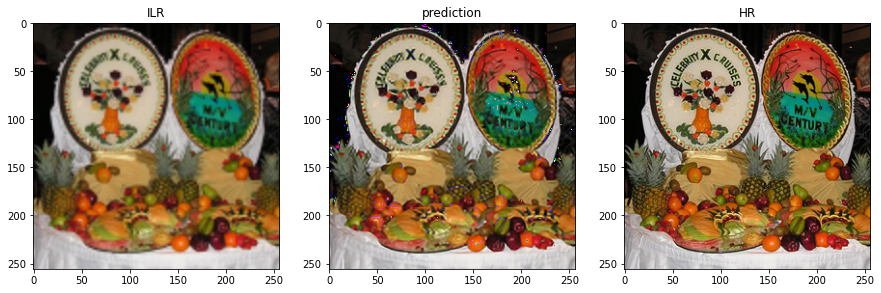

In [ ]:
from matplotlib import pyplot as plt
import cv2
import math
from tensorflow.keras import backend as k


def imgappend(img_pieces, length_num, width_num):
  num = 0
  for i in range(0, length_num):
    for j in range(0, width_num):
      if j == 0:
        width_array = img_pieces[num, :, :]
      else:
        width_array = np.append(width_array, img_pieces[num, :, :, :], axis=1)  # 横向拼接
      num += 1
    if i == 0:
      length_array = width_array.copy()
    else:
      length_array = np.append(length_array, width_array, axis=0)  # 纵向拼接
  return length_array


def getYimg(ILR_img, pred_img, HR_img, LR_res, HR_res):
  HR_img = np.reshape(HR_img, (HR_img.shape[0], HR_img.shape[1], 1))
  ILR_img = np.reshape(ILR_img, (ILR_img.shape[0], ILR_img.shape[1], 1))
  pred_img = np.reshape(pred_img, (ILR_img.shape[0], ILR_img.shape[1], 1))
  ILR_res = cv2.resize(LR_res, (LR_res.shape[1]*scale, LR_res.shape[0]*scale), interpolation = cv2.INTER_LINEAR)
  HR_res = HR_res[:HR_img.shape[0], :HR_img.shape[1], :]
  ILR_res = ILR_res[:ILR_img.shape[0], :ILR_img.shape[1], :]
  HR_img = np.append(HR_img, HR_res, axis=2)
  ILR_img = np.append(ILR_img, ILR_res, axis=2)
  pred_img = np.append(pred_img, ILR_res, axis=2)
  ILR_img = cv2.cvtColor(ILR_img, cv2.COLOR_YCR_CB2BGR)
  pred_img = cv2.cvtColor(pred_img, cv2.COLOR_YCR_CB2BGR)
  HR_img = cv2.cvtColor(HR_img, cv2.COLOR_YCR_CB2BGR)
  return ILR_img, pred_img, HR_img


def psnr(y_true, y_pred):
  y_true = cv2.cvtColor(y_true, cv2.COLOR_BGR2YCR_CB)
  y_pred = cv2.cvtColor(y_pred, cv2.COLOR_BGR2YCR_CB)
  y_true = y_true[:, :, 0]
  y_pred = y_pred[:, :, 0]
  mse = np.mean((y_true/1.0 - y_pred/1.0) ** 2 )
  return 10 * math.log10(255.0**2/mse)

def ssim(y_true,y_pred):
    u_true = k.mean(K.constant(y_true))
    u_true = K.get_value(u_true)
    u_pred = k.mean(K.constant(y_pred))
    u_pred =  K.get_value(u_pred)
    var_true = k.var(K.constant(y_true))
    var_true =  K.get_value(var_true)
    var_pred = k.var(K.constant(y_pred))
    var_pred =  K.get_value(var_pred)
    std_true = k.sqrt(K.constant(var_true))
    std_true =  K.get_value(std_true)
    std_pred = k.sqrt(K.constant(var_pred))
    std_pred =  K.get_value(std_pred)
    c1 = k.square(K.constant(0.01*7))
    c1 =  K.get_value(c1)
    c2 = k.square(K.constant(0.03*7))
    c2 =  K.get_value(c2)
    ssim = (2 * u_true * u_pred + c1) * (2 * std_pred * std_true + c2)
    denom = (u_true ** 2 + u_pred ** 2 + c1) * (var_pred + var_true + c2)
    return ssim / denom

def ber(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    labels, number = np.unique(y_true, return_counts=True)
    acc = [np.sum(np.logical_and([labels[i] == y_true], [labels[i] == y_pred]))/number[i] for i in range(len(labels))]
    return np.mean(acc)

y_pred = model.predict(x_test)

length_num = HR_img.shape[0] // (size * scale)
width_num = HR_img.shape[1] // (size * scale)
pred_img = imgappend(y_pred, length_num, width_num)
pred_img = (pred_img * 255).astype(np.uint8)
if Imgflag == 0:
  HR_img = HR_img[:pred_img.shape[0], :pred_img.shape[1], :pred_img.shape[2]]
  LR_img = LR_img[:pred_img.shape[0]//scale, :pred_img.shape[1]//scale, :pred_img.shape[2]]
else:
  HR_img = HR_img[:pred_img.shape[0], :pred_img.shape[1]]
  LR_img = LR_img[:pred_img.shape[0]//scale, :pred_img.shape[1]//scale]
  pred_img = np.reshape(pred_img, (pred_img.shape[0], pred_img.shape[1]))
ILR_img = cv2.resize(LR_img, (LR_img.shape[1]*scale, LR_img.shape[0]*scale), interpolation = cv2.INTER_LINEAR)
if Imgflag == 2:
  ILR_img, pred_img, HR_img = getYimg(ILR_img, pred_img, HR_img, LR_res, HR_res)


if Imgflag != 1:
  cmap = None
  print('PSNR between ILR and HR:', psnr(HR_img, ILR_img))
  print('PSNR between output and HR:', psnr(HR_img, pred_img), '\n')

  print('SSIM between ILR and HR:', ssim(HR_img, ILR_img))
  print('SSIM between output and HR:', ssim(HR_img, pred_img), '\n')

  print('BER between ILR and HR:', ber(HR_img, ILR_img))
  print('BER between output and HR:', ber(HR_img, pred_img), '\n')

  b,g,r = cv2.split(pred_img)
  pred_img = cv2.merge([r,g,b])
  b,g,r = cv2.split(HR_img)
  HR_img = cv2.merge([r,g,b])
  b,g,r = cv2.split(ILR_img)
  ILR_img = cv2.merge([r,g,b])
else:
  cmap = plt.cm.gray

plt.figure(figsize=(15, 15))

plt.subplot(1,3,1)
plt.imshow(ILR_img, cmap)
plt.title("ILR")

plt.subplot(1,3,2)
plt.imshow(pred_img, cmap)
plt.title("prediction")

plt.subplot(1,3,3)
plt.imshow(HR_img, cmap)
plt.title("HR")

plt.show()